In [50]:
from LogErrLoader import LoadDNDSLogErr
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from scipy.ndimage import uniform_filter1d


def windowed_std(arr, window_size: int):
    mean = uniform_filter1d(arr, size=window_size, mode="reflect")
    mean_sq = uniform_filter1d(arr**2, size=window_size, mode="reflect")
    std = np.sqrt(mean_sq - mean**2)
    return std


base = "CRM_0_VRes"
name_map = {
    "O4_0_NoDriVRes": "gmres5x1ilu",
    "O4_0_NoDriVRes_MG4jc2-4jc2-cor": "gmres5x1ilu-4ilu-4ilu",
    "O4_0_NoDriVRes_MG4jc2-4jc2": "gmres5x1ilu-4ilu",
}

log_names = os.listdir(base)
log_names.sort()
log_names = list(filter(lambda s: s.endswith(".log"), log_names))
print(log_names)
data_list = []
data_list_resMaxes = {}
for log in log_names:
    m = re.match(r"([\w-]+)_.log", log)
    name = m.group(1)
    if name in name_map.keys():
        name = name_map[name]
    else:
        continue
    data = LoadDNDSLogErr(os.path.join(base, log))
    data_list.append((data, name))
    for key in data:
        max_v = np.array(data[key]).max()
        if key.startswith("res"):
            data_list_resMaxes[key] = (
                max(data_list_resMaxes[key], max_v)
                if key in data_list_resMaxes.keys()
                else max_v
            )
for data, name in data_list:
    print(name)


lwc = 1
msc = 10
markEvery = 300
markerList = (
    ".",
    "o",
    "v",
    "^",
    "<",
    ">",
    "8",
    "s",
    "p",
    "*",
    "h",
    "H",
    "D",
    "d",
    "P",
    "X",
)


def plotOne(data, label, plotIndex=0, xAxis="tWall", yAxis="res0", std=0):
    dataY = np.array(data[yAxis][0:-1])
    if std > 0:
        dataY = windowed_std(dataY, std)
    if yAxis.startswith("res"):
        dataY /= data_list_resMaxes[yAxis]
    dataX = np.array(data[xAxis][0:-1])
    if xAxis == "tWall":
        dataX -= dataX[0]
    plt.plot(
        dataX,
        dataY,
        label=label,
        lw=lwc,
        marker=markerList[plotIndex],
        markevery=markEvery,
        markersize=msc,
    )
    return plotIndex + 1


def plotAfter(xlim, xlabel="t", ylabel="res0", logy=True):
    if logy:
        plt.yscale("log")
    leg = plt.legend()
    plt.xlim(xlim)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(visible=True, which="both", alpha=0.3)


# series = ["all", "ilu", "lusgs", "gmres"]
series = ["all"]
tRanges = [70000, 500, 700, 250]

['O4_0_NoDriVRes_.log', 'O4_0_NoDriVRes_MG4jc2-4jc2-cor_.log', 'O4_0_NoDriVRes_MG4jc2-4jc2_.log', 'O4_0_NoDriVRes_MG4jc2_.log', 'O4_0_NoDriVRes_stalled_.log']
gmres5x1ilu
gmres5x1ilu-4ilu-4ilu
gmres5x1ilu-4ilu


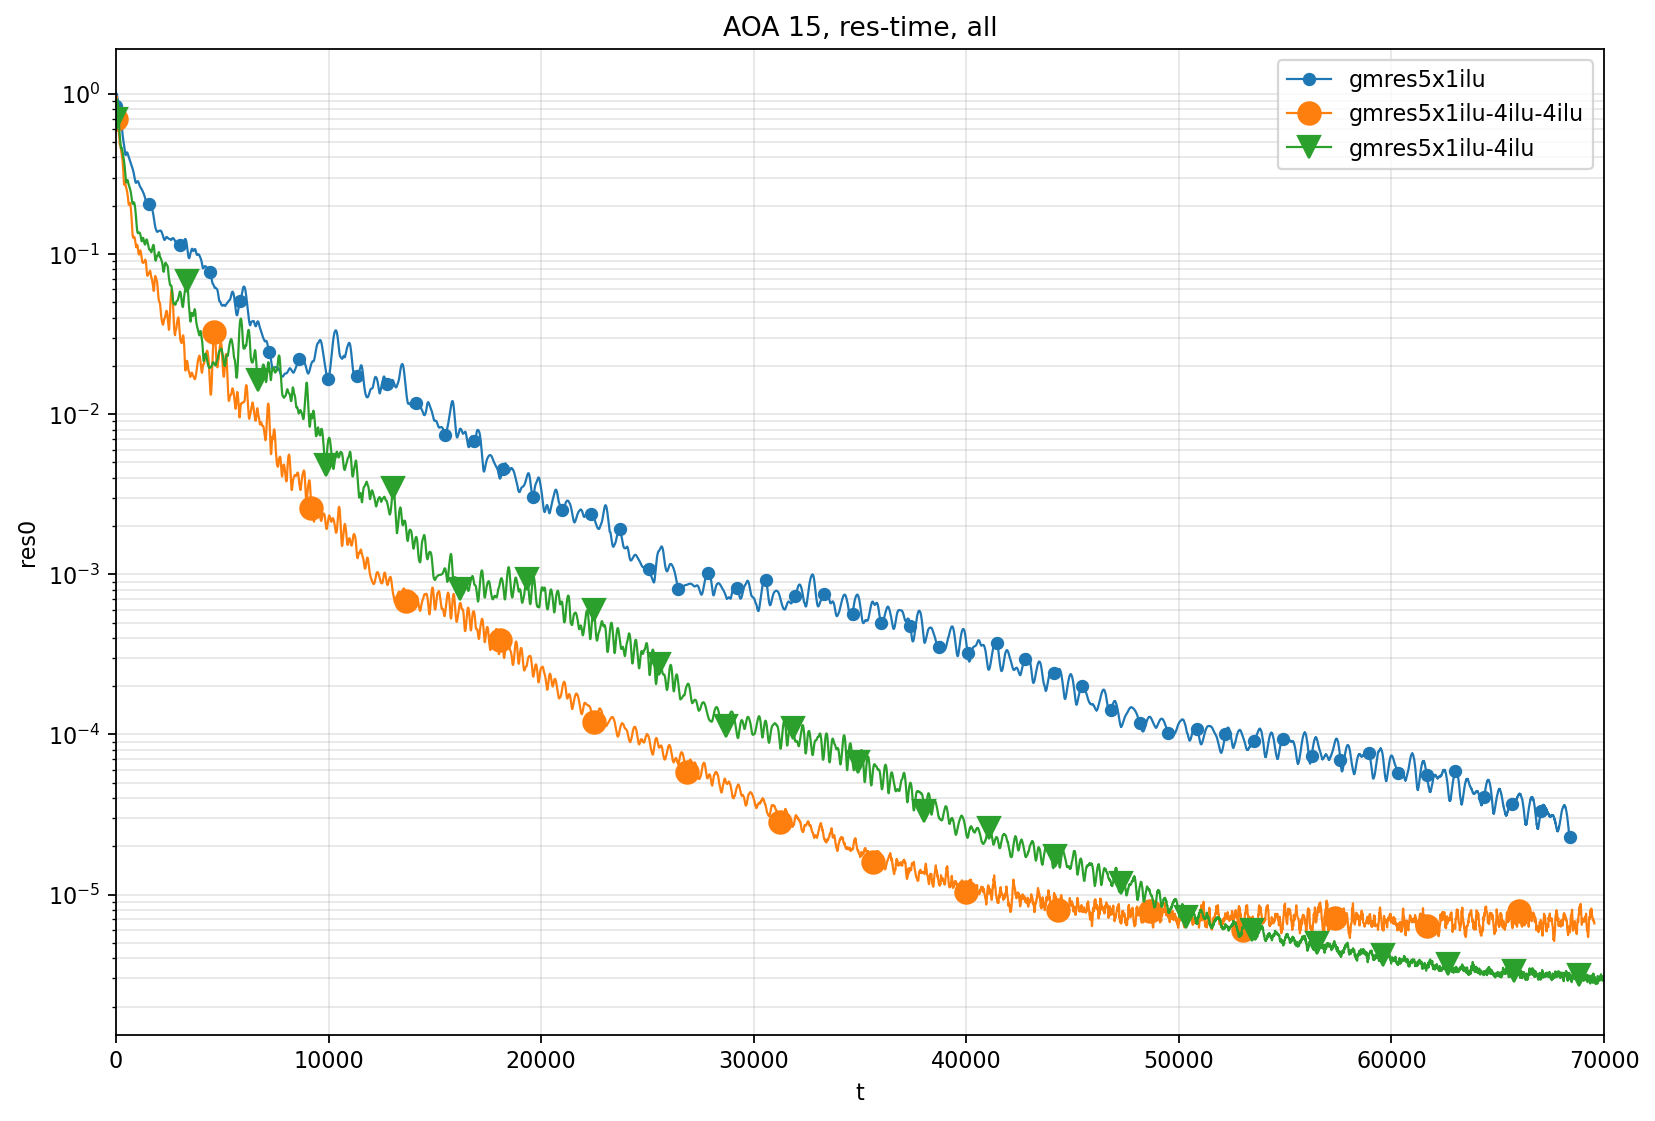

In [51]:
for ifig, subset in enumerate(series):
    if subset == "all":
        head = ""
    else:
        head = subset

    plt.figure(1003 + 10000*ifig,figsize=(12, 8), dpi=160)
    plt.title(f"AOA 15, res-time, {subset}")
    for i, (data, name) in enumerate(data_list):
        if name.startswith(head):
            plotOne(data, name, i, xAxis="tWall", yAxis="res0")
    plotAfter((0,tRanges[ifig]), xlabel="t")
    plt.savefig(f"crm_noDri_VRes_rt_{subset}.png")

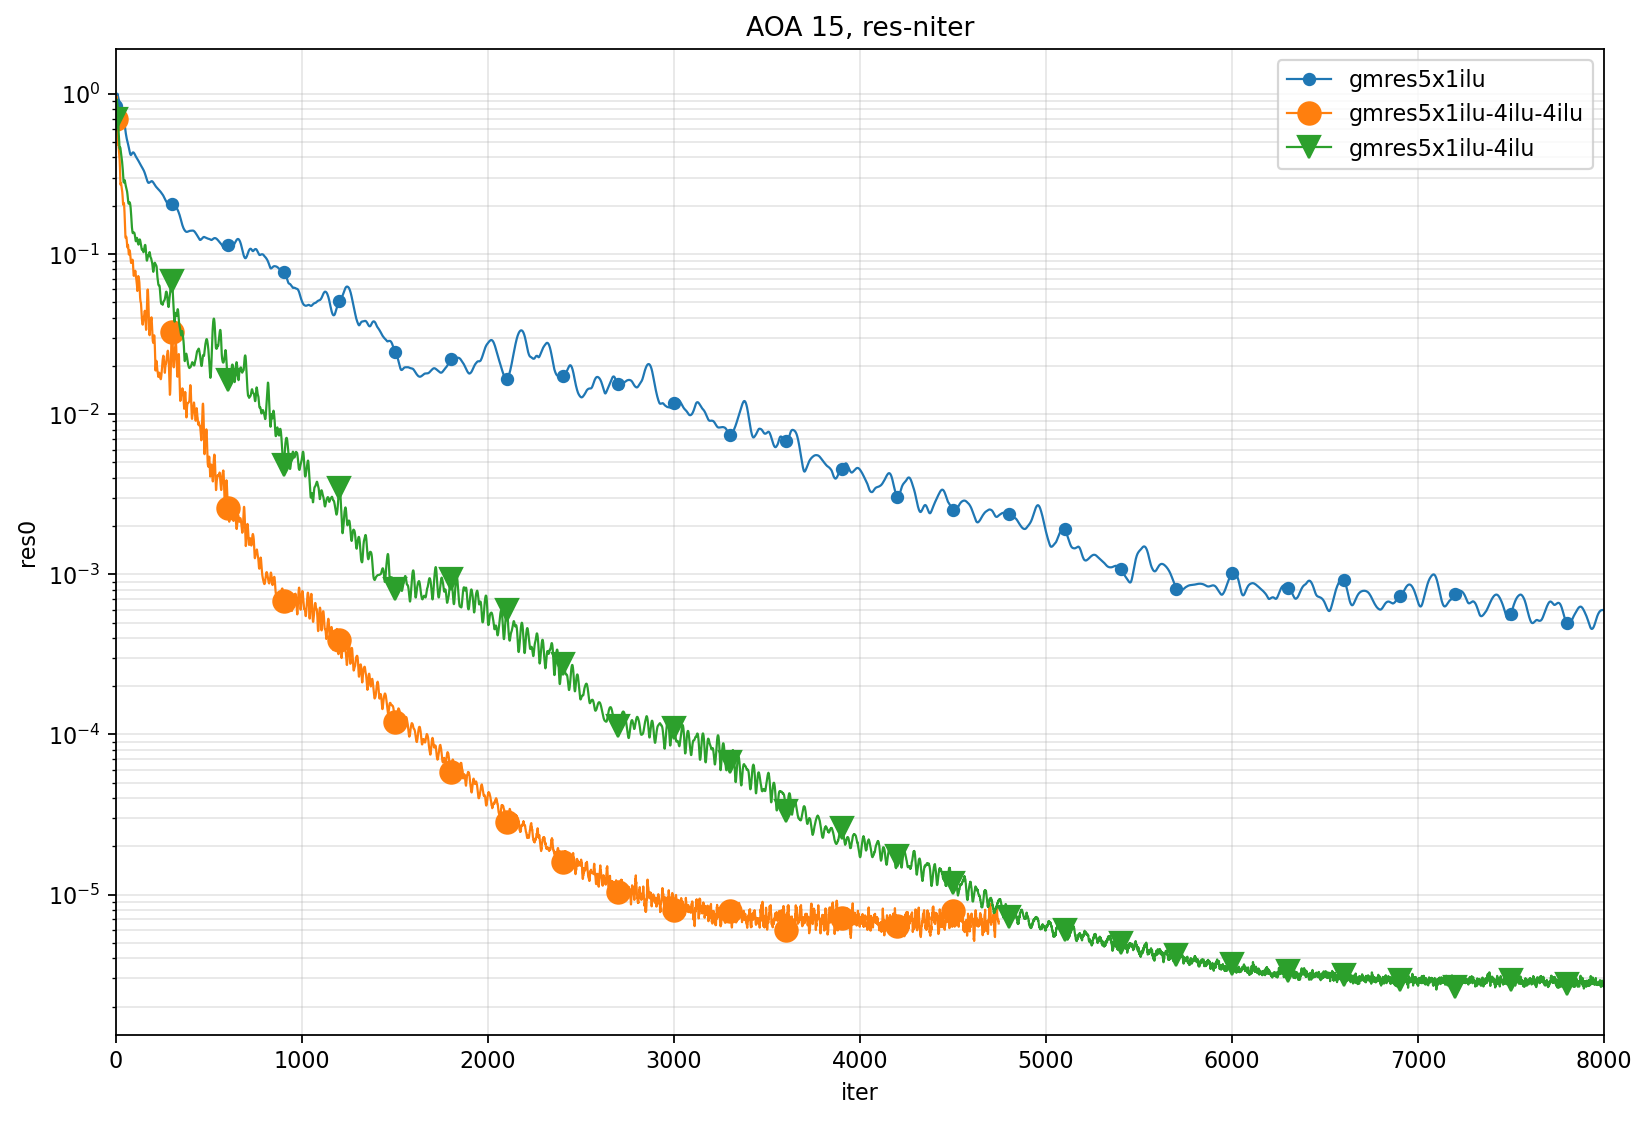

In [52]:
plt.figure(1004, figsize=(12, 8), dpi=160)
plt.title("AOA 15, res-niter")
for i, (data, name) in enumerate(data_list):
    plotOne(data, name, i, xAxis="iter", yAxis="res0")
plotAfter((0, 8000), xlabel="iter")
plt.savefig(f"crm_noDri_VRes_ri_{"all"}.png")

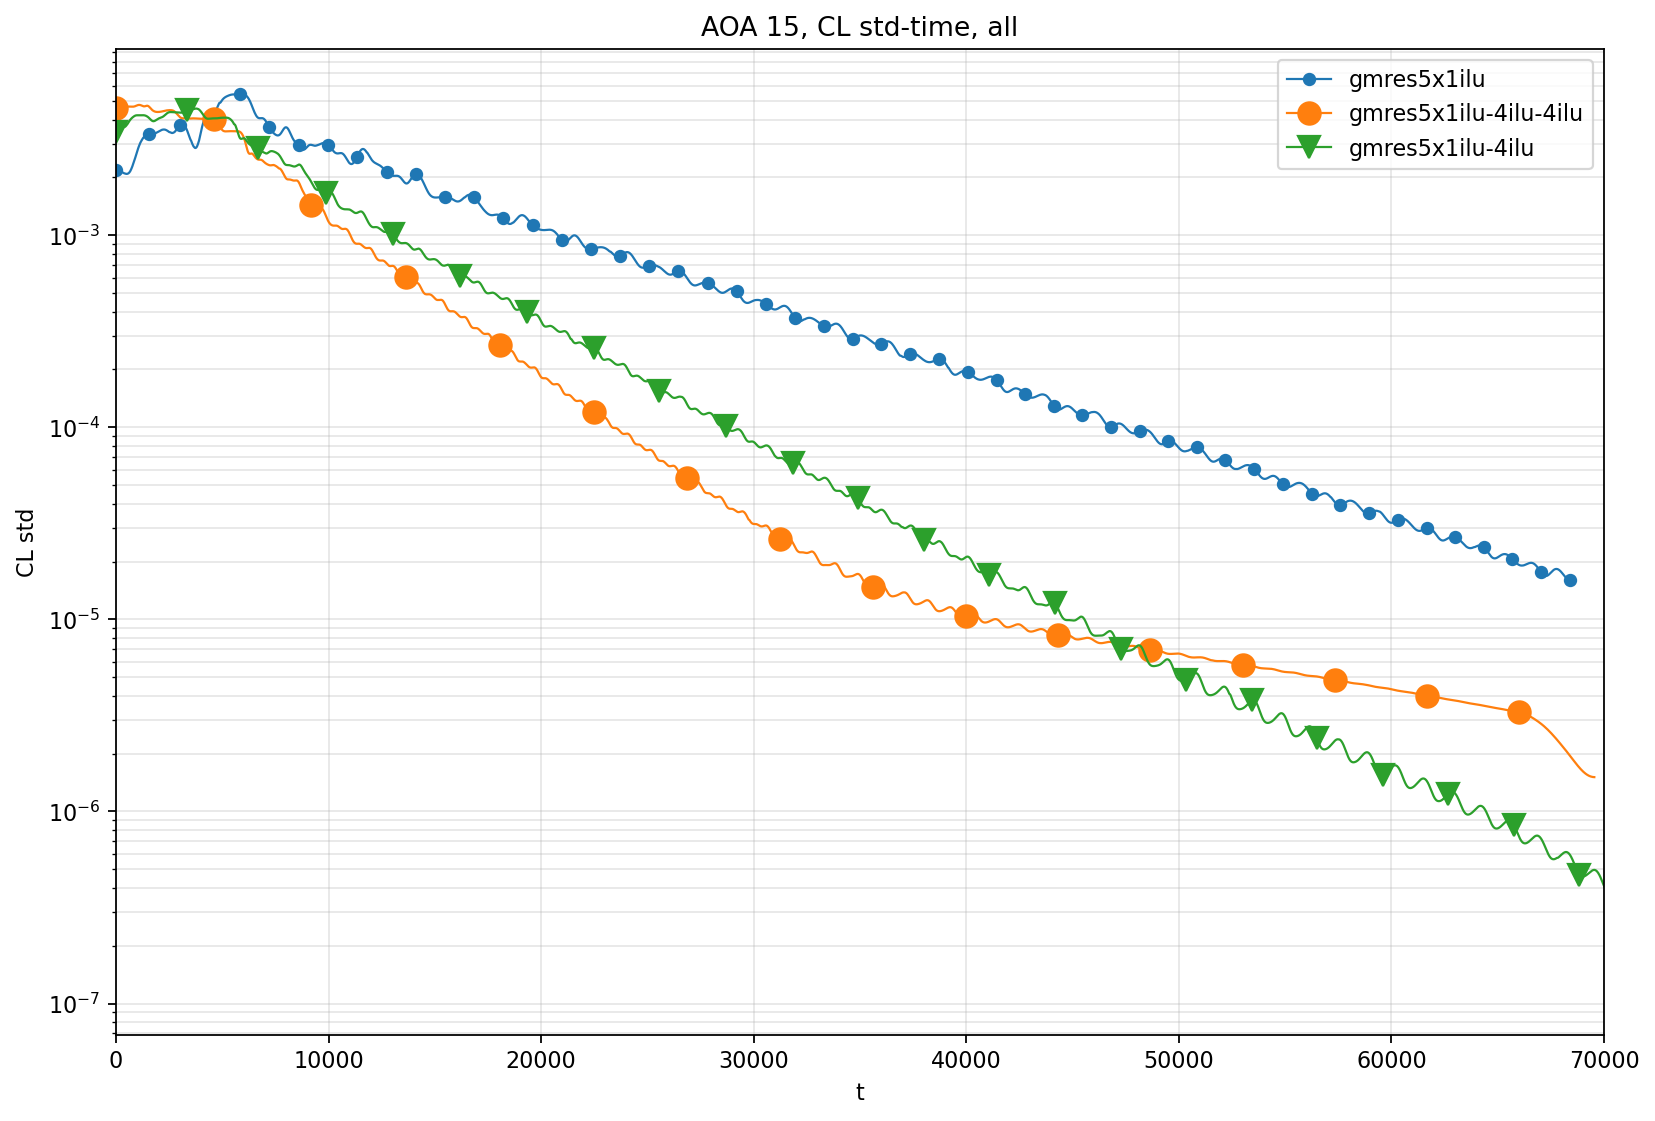

In [53]:
for ifig, subset in enumerate(series):
    if subset == "all":
        head = ""
    else:
        head = subset

    plt.figure(1005 + 10000*ifig,figsize=(12, 8), dpi=160)
    plt.title(f"AOA 15, CL std-time, {subset}")
    for i, (data, name) in enumerate(data_list):
        if name.startswith(head):
            plotOne(data, name, i, xAxis="tWall", yAxis="CL", std=500)
    plotAfter((0,tRanges[ifig]), xlabel="t", ylabel= "CL std")
    plt.savefig(f"crm_noDri_VRes_clstdT_{subset}.png")

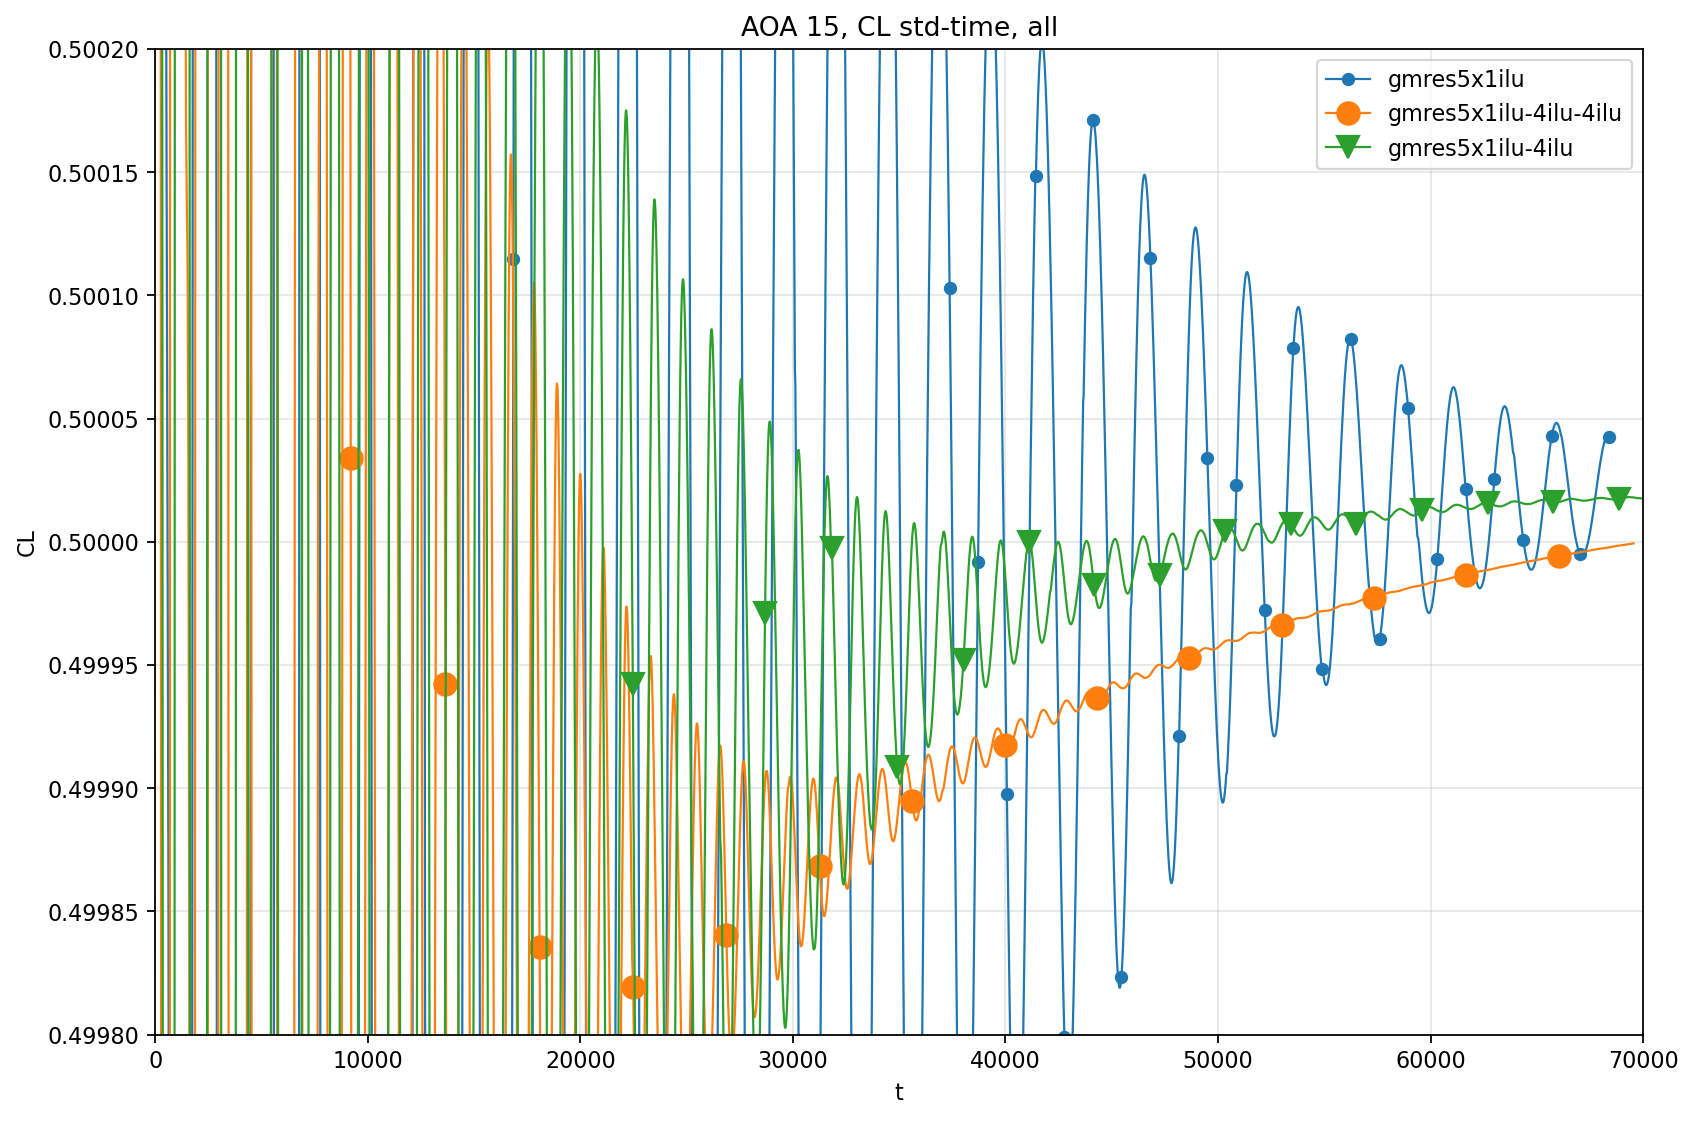

In [54]:
for ifig, subset in enumerate(series):
    if subset == "all":
        head = ""
    else:
        head = subset

    plt.figure(1005 + 10000 * ifig, figsize=(12, 8), dpi=160)
    plt.title(f"AOA 15, CL std-time, {subset}")
    for i, (data, name) in enumerate(data_list):
        if name.startswith(head):
            plotOne(data, name, i, xAxis="tWall", yAxis="CL")
    plotAfter((0, tRanges[ifig]), xlabel="t", ylabel="CL", logy=False)
    plt.ylim(np.array([-1,1]) * 2e-4 + 0.5)
    plt.savefig(f"crm_noDri_VRes_cl_{subset}.png")